In [2]:
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
        
PATH = 'input'

sample_df = pd.read_csv('input/sample_submission.csv')
test_ids = sample_df.id.values

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import KFold

FOLDS_CSV = os.path.join(PATH, 'folds.csv')
def generate_folds():
    n_fold = 5
    depths = pd.read_csv(os.path.join(PATH, 'depths.csv'))
    depths.sort_values('z', inplace=True)
    depths.drop('z', axis=1, inplace=True)
    depths['fold'] = (list(range(n_fold))*depths.shape[0])[:depths.shape[0]]
    print(depths.head())
    depths.to_csv(FOLDS_CSV, index=False)

if not os.path.exists(FOLDS_CSV):
    generate_folds()


In [4]:
im_width = 128
im_height = 128
im_chan = 1

In [5]:
X_train = np.load('input/X_train_128.npy')
y_train = np.load('input/y_train_128.npy')
X_test = np.load('input/X_test_128.npy')

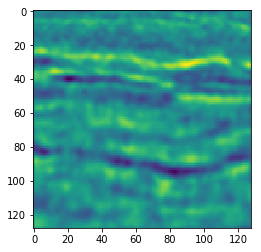

In [6]:
plt.imshow((X_train[0,:,:,0]+0.5)*255)

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def build_unet2(dropout_val=0.2, weights=None):
    if K.image_dim_ordering() == 'th':
        inputs = Input((im_height, im_width, im_chan), name='inputs1')
        axis = 1
    else:
        inputs = Input((im_height, im_width, im_chan), name='inputs1')
        axis = 3

    filters = 8
    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    output_mask_channels = 1
    conv_final = Conv2D(output_mask_channels, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)    

    model = Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss=dice_coef_loss)
    return model


In [19]:
def load_fold(X_train, y_train, fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    
    fold_train = [fold_dict[x]!=fold for x in train_ids]
    fold_val = [fold_dict[x]==fold for x in train_ids]
    
    X_fold, y_fold = X_train[fold_train], y_train[fold_train]    
    X_val, y_val = X_train[fold_val], y_train[fold_val]    
    return X_fold, y_fold, X_val, y_val



In [36]:
def run_fold(X_fold, y_fold, X_val, y_val, weights_file):
    model = build_unet2()
        
    callbacks = [
        EarlyStopping(patience=5, verbose=1),
        ReduceLROnPlateau(patience=3, verbose=1),
        ModelCheckpoint(weights_file, verbose=1, save_best_only=True)
    ]
        
    data_gen_args = dict(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.2
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    seed = 1
    image_datagen.fit(X_fold, augment=True, seed=seed)
    mask_datagen.fit(y_fold, augment=True, seed=seed)

    image_generator = image_datagen.flow(X_fold, batch_size=32, seed=seed)
    mask_generator = mask_datagen.flow(y_fold, batch_size=32, seed=seed)    
    train_generator = zip(image_generator, mask_generator)

    results = model.fit_generator(
        train_generator, 
        epochs=100, 
        steps_per_epoch=len(X_fold)//32,
        callbacks=callbacks,
        validation_data=(X_val, y_val))

    return model

In [37]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


running fold  1
Epoch 1/100
99/99 [==============================] - 16s 165ms/step - loss: -0.5392 - val_loss: -0.5471

Epoch 00001: val_loss improved from inf to -0.54706, saving model to model-tgs-salt-fold1.h5
Epoch 2/100
99/99 [==============================] - 8s 78ms/step - loss: -0.6274 - val_loss: -0.5618

Epoch 00002: val_loss improved from -0.54706 to -0.56179, saving model to model-tgs-salt-fold1.h5
Epoch 3/100
99/99 [==============================] - 8s 78ms/step - loss: -0.6805 - val_loss: -0.6422

Epoch 00003: val_loss improved from -0.56179 to -0.64219, saving model to model-tgs-salt-fold1.h5
Epoch 4/100
99/99 [==============================] - 8s 78ms/step - loss: -0.7118 - val_loss: -0.7457

Epoch 00004: val_loss improved from -0.64219 to -0.74566, saving model to model-tgs-salt-fold1.h5
Epoch 5/100
99/99 [==============================] - 8s 78ms/step - loss: -0.7317 - val_loss: -0.7116

Epoch 00005: val_loss did not improve
Epoch 6/100
99/99 [=======================

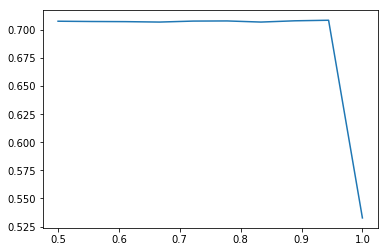

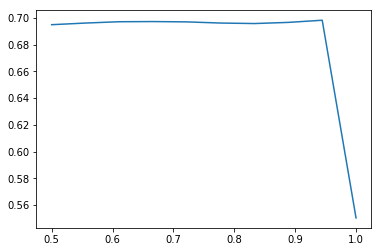

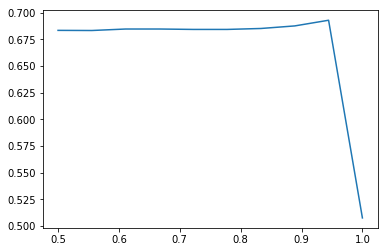

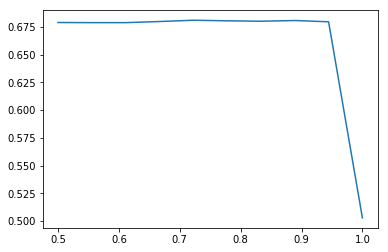

In [38]:
for fold in range(5):
    if fold == 0:
        continue
    print('running fold ', fold)
    X_fold, y_fold, X_val, y_val = load_fold(X_train, y_train, fold)
    weights_file = f"model-tgs-salt-fold{fold}.h5"    
    
    run_fold(X_fold, y_fold, X_val, y_val, weights_file)
    
    model = build_unet2()
    model.load_weights(weights_file)
    model.evaluate(X_val, y_val, verbose=1)
    
    preds_val = model.predict(X_val, verbose=1)
    preds_test = model.predict(X_test, verbose=1)
    
    thres = np.linspace(0.5, 1.0, 10)
    thres_ioc = [iou_metric_batch(y_val, np.int32(preds_val > t)) for t in thres]
    
    plt.figure()
    plt.plot(thres, thres_ioc);
    best_thres = thres[np.argmax(thres_ioc)]
    print(best_thres, max(thres_ioc))
    
    preds = preds_test > best_thres # threshold
    np.save(f"preds_fold{fold}", preds)

In [42]:
preds = np.zeros_like(X_test)
for fold in range(5):
    p = np.load('preds_fold%s.npy' % fold)
    preds += p
preds /= 5

In [47]:
preds_ = []
for i in tqdm(range(len(preds_test))):
    preds_.append(resize(np.squeeze(preds[i]), (101, 101), mode='constant', preserve_range=True))

  0%|          | 0/18000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 18000/18000 [00:15<00:00, 1164.18it/s]


In [48]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs



In [57]:

rows = []
for image_id, p in zip(test_ids, preds_):
    rows.append([image_id, RLenc(np.round(p))])
    
sub = pd.DataFrame(rows, columns=['id', 'rle_mask'])
sub.to_csv('submissions/subm_004.csv', index=False)

NameError: name 'IntProgress' is not defined